In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [10]:
# Conventions



In [11]:
# This code compares Glover 2010 and Koyama 2000's approaches to CO cooling and demonstrates that they produce similar results.

In [12]:
# Functions

def Koyama_2000_rot(n, T):
    '''
    Rotational CO cooling rate coefficient from Koyama_2000, McKee 1982, and HM89.
    Important: Assumes total cooling rate per volume = this coefficient * n * nCO
    Note: T_3 = T/10^3 K
    Inputs:
    * n: Number density of hydrogen nuclei in cgs.
    * T: Temperature in K.
    
    Outputs:
    * L: The coefficient in erg cm^3 s^-1
    '''
    
    # Constants
    k_B = 1.3806e-16 # Boltsmann's constant in cgs
    A_0 = 9.7e-8 # A constant in s^-1
    E_0 = 2.76 * k_B # Another constant, in erg
    n_cr = 3.3e6 * (T/1e3)**(3./4) # A constant specific for 12CO in cm^-3
    
    L = 4*((k_B*T)**2)*A_0 / (n * E_0 * (1 + (n_cr/n) + 1.5*((n_cr/n)**0.5)))
    return L

def Koyama_2000_vib(T):
    '''
    Vibrational CO cooling rate coefficient from Koyama_2000, McKee 1982, and HM89. Takes into account collisions with H and H2 for transitions to the first excited state.
    Important: Definition is unclear, probably cooling rate per volume = this coefficient * nH2 * nCO
    Inputs:
    * T: Temperature in K.
    
    Outputs:
    * L: The coefficient in erg cm^3 s^-1
    '''
    
    # Constants
    k_B = 1.3806e-16 # Boltsmann's constant in cgs
    delta_E_10 = 3080 * k_B # Energy of the transition between v=0 and v=1 of CO. I believe there's a typo here in Koyama 2000 (A11).
    #gamma_H = 3.0e-12 * (T**0.5) * np.exp(-(2000/T)**3.43) * np.exp(-3080/T) # vibrational rate coefficient for transition for H in s^-1
    gamma_H = 0
    gamma_H2 = 4.3e-14 * T * np.exp(-(3.14e5/T)**0.333) * np.exp(-3080/T) # vibrational rate coefficient for transition for H2 in s^-1
    
    L = delta_E_10 * (gamma_H + gamma_H2)
    return L

In [13]:
# Parameters for Koyama
T_Koyama = np.logspace(1, 4, num=2000, base=10) # Generate temperatures
n = 0.1 # cm^-3
nH2 = n/2 # Assume fully molecular gas
nHI = 100 - nH2 * 2
xe = 1e-4 # Relative abundance of e-
ne = n * xe
Koyama_rot = Koyama_2000_rot(n, T_Koyama) * 2
Koyama_vib = Koyama_2000_vib(T_Koyama)

# Important: Definition for Neufeld is cooling rate per volume = this coefficient * nH2 * nCO

# Parameters for Neufeld rotational
T_Neufeld_rot = np.array([100, 300, 600, 1000, 1500, 2000]) # For log10(N tilde) = 14.0, which is presumably optically thin
#L_0_Neufeld_rot = np.power(10, -np.array([23.88, 23.40, 23.07, 22.81, 22.61, 22.47]))
#L_LTE_Neufeld_rot = np.power(10, -np.array([18.81, 17.82, 17.23, 16.82, 16.52, 16.33]))
#n_half_Neufeld_rot = np.power(10, np.array([4.43, 4.95, 5.25, 5.43, 5.57, 5.68]))
#alpha_Neufeld_rot = np.array([0.39, 0.38, 0.38, 0.37, 0.36, 0.35])
L_0_Neufeld_rot = np.power(10, -np.array([23.82, 23.42, 23.13, 22.91, 22.63, 22.28]))
L_LTE_Neufeld_rot = np.power(10, -np.array([18.80, 17.81, 17.23, 16.86, 16.66, 16.55]))
n_half_Neufeld_rot = np.power(10, np.array([4.46, 5.17, 5.47, 5.53, 5.30, 4.70]))
alpha_Neufeld_rot = np.array([0.357, 0.385, 0.437, 0.428, 0.354, 0.322])

# n_eff calculation
n_eff_Neufeld_rot = nH2 + np.sqrt(2)*(2.3e-15/3.3e-16)*nHI + 1.3e-8/(3.3e-16*1.03e4*np.power(T_Neufeld_rot, 0.5)) * ne

Neufeld_rot = 1/(1/L_0_Neufeld_rot + n_eff_Neufeld_rot/L_LTE_Neufeld_rot + 1/L_0_Neufeld_rot * np.power(n_eff_Neufeld_rot/n_half_Neufeld_rot, alpha_Neufeld_rot) * (1 - n_half_Neufeld_rot*L_0_Neufeld_rot/L_LTE_Neufeld_rot))

# Parameters for Neufeld vibrational
T_Neufeld_vib = np.array([100, 200, 400, 1000, 2000, 4000]) # For log10(N tilde) = 13.0, which is presumably optically thin
L_0_Neufeld_vib = 1.83e-26 * T_Neufeld_vib * np.exp(-68.0/np.power(T_Neufeld_vib, 1/3)) * np.exp(-3080/T_Neufeld_vib)
L_LTE_Neufeld_vib = np.power(10, -(np.array([10.83, 10.82, 10.82, 10.80, 10.77, 10.79]) + 3080/T_Neufeld_vib/np.log(10)))

# n_eff calculation
L_CO0_Neufeld_vib = 1.14e-14 * np.exp(-68.0/np.power(T_Neufeld_vib, 1/3)) * np.exp(-3080/T_Neufeld_vib)
L_COe_Neufeld_vib = 1.03e-10 * np.power(T_Neufeld_vib/300, 0.938) * np.exp(-3080/T_Neufeld_vib)
n_eff_Neufeld_vib = nH2 + 50*nHI + L_CO0_Neufeld_vib / L_COe_Neufeld_vib * ne

Neufeld_vib = 1/(1/L_0_Neufeld_vib + n_eff_Neufeld_vib/L_LTE_Neufeld_vib)


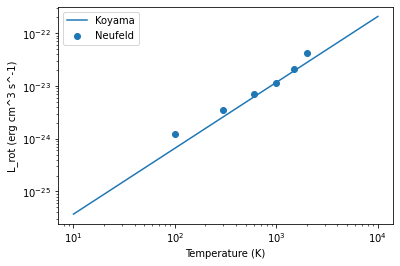

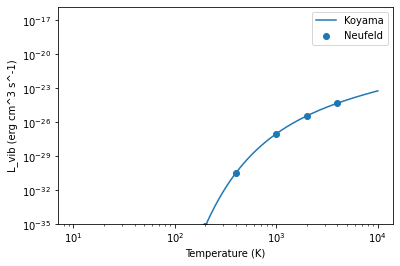

In [14]:
# Plot rotational cooling rate coefficient
fig_rot, ax_rot = plt.subplots()
Koyama_line_rot, = ax_rot.plot(T_Koyama, Koyama_rot)
Neufeld_scatter_rot = ax_rot.scatter(T_Neufeld_rot, Neufeld_rot)
ax_rot.set_xlabel('Temperature (K)')
ax_rot.set_ylabel('L_rot (erg cm^3 s^-1)')
ax_rot.set_xscale('log')
ax_rot.set_yscale('log')

# Plot vibrational cooling rate coefficient
fig_vib, ax_vib = plt.subplots()
Koyama_line_vib, = ax_vib.plot(T_Koyama, Koyama_vib)
Neufeld_scatter_vib = ax_vib.scatter(T_Neufeld_vib, Neufeld_vib)
ax_vib.set_xlabel('Temperature (K)')
ax_vib.set_ylabel('L_vib (erg cm^3 s^-1)')
ax_vib.set_xscale('log')
ax_vib.set_yscale('log')
ax_vib.set_ylim(bottom=1e-35)

# Add legend
ax_rot.legend([Koyama_line_rot, Neufeld_scatter_rot], ['Koyama', 'Neufeld'])
ax_vib.legend([Koyama_line_vib, Neufeld_scatter_vib], ['Koyama', 'Neufeld'])

In [15]:
# Save the graphs as pdfs
pp = PdfPages('CO_cooling.pdf')
pp.savefig(fig_rot)
pp.savefig(fig_vib)
pp.close()

In [16]:
Neufeld_rot

array([1.23413582e-24, 3.47236466e-24, 7.03840737e-24, 1.16262921e-23,
       2.09120063e-23, 4.17297778e-23])